## Part 2 - SVD and PCA

In the previous part, we introduced you to dimensionality reduction and we showed you how to do it with simple heuristics, feature engineering, and even with statistical methods. But, as mentioned, these methods lack information such as interaction between features and can be over-simplified for our purposes. This is where algebra kicks in to help us out.

![morpheus-algebra](./media/what-if-i-told-you.jpg)


Never thought you'd use algebra again, right? Guess again, Neo.

### Table of contents
[1. Singular value decomposition](#1.-Singular-value-decomposition)   
&emsp;[1.1 Basic linear algebra](#1.1-Basic-linear-algebra)   
&emsp;[1.2 Eigenvalues and eigenvectors](#1.2-Eigenvalues-and-eigenvectors)   
&emsp;[1.3 Defining the singular value decomposition (SVD)](#1.3-Defining-the-singular-value-decomposition-(SVD))   
&emsp;&emsp;[1.3.1 - Choose A](#1.3.1-Choose-A)   
&emsp;&emsp;[1.3.2 - Build U](#1.3.2-Build-U)   
&emsp;&emsp;[1.3.3 Build V^T](#1.3.3-Build-V^T)   
&emsp;&emsp;[1.3.4 Create S](#1.3.4-Create-S)   
&emsp;[1.4 Using SVD for dimensionality reduction](#1.4-Using-SVD-for-dimensionality-reduction)   
&emsp;[1.5 Putting it all together](#1.5-Putting-it-all-together)   
[2. SVD - NLP practical example using sk-learn](#2.-SVD---NLP-practical-example-using-sk-learn)   
&emsp;[2.1 Start from baseline](#2.1-Start-from-baseline)   
&emsp;[2.2 Applying SVD](#2.2-Applying-SVD)   
[3. Principal component analysis](#3.-Principal-component-analysis)   
&emsp;[3.1 Getting the first principal component](#3.1-Getting-the-first-principal-component)    
&emsp;&emsp;[TL,DR:](#TL,DR:)   
&emsp;&emsp;[3.1.1 Choose A](#3.1.1-Choose-A)   
&emsp;&emsp;[3.1.2 Center A and compute the covariance matrix](#3.1.2-Center-A-and-compute-the-covariance-matrix)   
&emsp;&emsp;[3.1.3 Get the covariance matrix eigenvalues](#3.1.3-Get-the-covariance-matrix-eigenvalues)   
&emsp;&emsp;[3.1.4 Project data into the first component](#3.1.4-Project-data-into-the-first-component)   
&emsp;[3.2 Putting it all together](#3.2-Putting-it-all-together)   
[4. PCA - NLP practical example using sk-learn](#4.-PCA---NLP-practical-example-using-sk-learn)   
&emsp;[4.1 Start from baseline](#4.1-Start-from-baseline)   
&emsp;[4.2 Applying PCA](#4.2-Applying-PCA)   
[5. Final remarks](#5.-Final-remarks)   

In [1]:
import string
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import barh,plot,yticks,show,grid,xlabel,figure,cla,close
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import WordPunctTokenizer
from scipy.sparse.linalg import svds
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

seed = 42

## 1. Singular value decomposition

The Singular Value Decomposition (SVD) method is a matrix decomposition or matrix factorization method, often used in applications such as compression, denoising and, our current topic, dimensionality reduction. All matrices have an SVD, making it more stable than other methods, such as the eigendecomposition. It is often presented with Principal Component Analysis (PCA), which we are going to dive into later, but it can actually be used by itself, so let's start with that.

The concept of SVD is relatively straightforward, but it is useful to understand the algebra behind it. I was actually going to assume that you are fresh on your basic linear algebra (don't roll your eyes at me), skip the primers and jump right to business, but then again, a little refresher doesn't hurt. 

## 1.1 Basic linear algebra

<img src="media/welcome-to-the-matrix.jpg" width="400">

A matrix is just a collection of values ordered in rows and collumns, such as the one that you created with count vectorizer or Tf-idf vectorizer.

$$
A = \begin{bmatrix} 
    x_{11}&x_{12}&.&.&.&.&x_{1N}\\
    x_{21}&x_{22}&.&.&.&.&x_{2N}\\
    .&.&.&.&.&.&.\\
    x_{M1}&x_{m2}&.&.&.&.&x_{MN}\\
\end{bmatrix}
$$

It has a known shape - in the case above M-by-N. Remember that a 1-by-N or M-by-1 shaped matrix is what we normally call a vector. There are also some typical operations that you can compute with the help of numpy, like the transpose:

$$
A = \begin{bmatrix} 
    a & b & c\\
    d & e & f \\
\end{bmatrix}
\quad A^T = \begin{bmatrix} 
    a & d \\
    b & e \\
    c & f 
\end{bmatrix}
$$

or the dot product, where the internal dimensions have to match:

$$
A = \begin{bmatrix} 
    a & b\\
\end{bmatrix} 
\quad B = \begin{bmatrix} 
    c \\ 
    d \\
\end{bmatrix} 
\quad AB = \begin{bmatrix} 
    ac + bd 
\end{bmatrix} 
\quad A^T B^T = \begin{bmatrix} 
    ac & ad \\ 
    bc & bd \\
\end{bmatrix}
$$

An important concept is also the determinant of a matrix, an operation applicable to squared matrices that yields a scalar value, that can be seen geometrically as the scaling factor of the linear transformation described by the matrix. For simple matrices, like 2-by-2 and 3-by-3, the expressions seem fairly simple:

$$ A = \begin{bmatrix} 
    a & b \\
    c & d \\
\end{bmatrix}
\quad|A| = ad − bc 
\quad \quad B = \begin{bmatrix} 
    a & b & c\\
    d & e & f \\
    g & h & i \\
\end{bmatrix}
\quad|B| = a(ei − fh) - b(di − fg) + c(dh − eg)
$$

But for matrices with higher numbers of rows or columns, these formulas will get complicated. For all these operations, if you wish to understand more about linear algebra, you'll have to study a bit. But for now, this should suffice to grasp the mathematics behind the SVD. First, try out a few of these operations (in particular the determinant) with numpy.

In [2]:
A = np.array([
    [1, 2],
    [3, 4],
    [1, 2],
    [1, 2],
    [3, 4],
    [1, 2],
])

# Print transpose
A_T = A.T
print(A_T)

# Use matrix multiplication
# np.multiply is the element-wise multiplication, while np.dot or np.matmul are matrix multiplications
A_mul = np.matmul(A, A_T)

# Compute determinant of 6x6 matrix
np.linalg.det(A_mul)

[[1 3 1 1 3 1]
 [2 4 2 2 4 2]]


0.0

## 1.2 Eigenvalues and eigenvectors

An eigenvector is a vector whose direction remains unchanged when a linear transformation is applied to it. If we consider a linear transformation as being represented by some matrix $M$, then what this means is that the product of this matrix by the eigenvector $v$ will just be a scaled version of $v$:

$$Mv=\lambda v$$

In this definition we exclude the zero-vector, since the multiplication would always be true for any scalar $ \lambda $. A method for finding the vectors $v$ - the **eigenvectors** - and their scalar counterparts $\lambda$ - the **eigenvalues** - is to treat the above as a linear system, and solve it. We are not going to do a demonstration of this method because the most common way of solving this is actually through algebra, using the determinant. We will not go deeper into how to compute this, since numpy makes it super easy, but you should at least understand the reasoning and know the basic equation that defines them.

In [3]:
# Compute eigenvalues and vectors of square matrix
lmbU, U = np.linalg.eig(A_mul)

print(lmbU)
print(U)

[6.95398321e+01 2.04574365e-15 4.60167922e-01 5.25800857e-18
 1.84646742e-31 1.96679229e-34]
[[-2.65922637e-01 -8.66025404e-01  4.23420773e-01 -9.90670284e-04
  -3.19011495e-03  3.85078767e-06]
 [-5.98807400e-01 -3.45791588e-15 -3.76071400e-01 -7.07106319e-01
   5.10245000e-01 -6.15916726e-04]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01  3.30223428e-04
   5.66325890e-01 -6.83611968e-04]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01  3.30223428e-04
  -2.82971311e-01 -7.06766385e-01]
 [-5.98807400e-01 -3.26716856e-15 -3.76071400e-01  7.07106319e-01
  -5.10245000e-01  6.15916726e-04]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01  3.30223428e-04
  -2.80164464e-01  7.07446147e-01]]


## 1.3 Defining the singular value decomposition (SVD)

The SVD of a matrix $A$ is just its factorization into the product of three matrices, $U$, $S$, and $V$ where the columns of U and V are orthonormal and $S$ is diagonal with positive real entries, described by the following:

$$ A = USV^T $$
 
* $A$: matrix we want to decompose (consider $A$ an M-by-N matrix)
* $U$: orthonormal matrix composed by eigenvectors of  $AA^T$. These eigenvectors are also called the 'left-singular' values of A. ($U$ is M-by-M)
* $V^T$: orthonormal matrix composed by eigenvectors of $A^TA$. These eigenvectors are also called the 'right-singular' values of A. ($V$ is N-by-N)
* $S$: diagonal matrix containing the square root of nonzero eigenvalues of $U$ (or $V$), ordered by decreasing size ($S$ is M-by-N). It is a property of these matrices that the nonzero eigenvalues of $U$ and $V$ are the same, this is, the eigenvectors of  $AA^T$ and $A^TA$ are related. The statistical interpretation of eigenvalues is a correspondence with the variance in the data explained by the various components each eigenvalue corresponds to.

Orthonormal matrices have the following property: $VV^T = I$. This is, their product with their transpose produces the identity matrix.

<br>

Let's try to perform a decomposition. First, let's define a matrix A.

### 1.3.1 Choose A

Let's create a very simple matrix  A, imagining we have a bunch of reviews that we classify as positive or negative from the words that appear there.

|          |  like | hate | not | love |
|----------|-------|------|-----|------|
| Positive |  5    |  0   |  2  |   4  |
| Negative |  2    |  6	  |  1  |   2  |


You can see how this matrix can grow with the number of examples and the number of n-grams considered which will typically lead to a larger vocabulary. Thus, you can understand why it is desirable to simplify it.

Start by defining the matrix:

In [4]:
A = np.array([
    [5, 0, 2, 4],
    [2, 6, 1, 2]
])

print("Matrix to decompose:")
print(A)

Matrix to decompose:
[[5 0 2 4]
 [2 6 1 2]]


Let's now create U, V and S from what we learned above:

### 1.3.2 Build U 

Remember that $U$ is composed by the eigenvectors of  $AA^T$.


In [5]:
AT = A.T
AAT = np.matmul(A, AT)

lmbU, U = np.linalg.eig(AAT)

print("\nEigenvectors:")
print(U)
print("\nEigenvalues:")
print(lmbU)


Eigenvectors:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

Eigenvalues:
[65. 25.]


### 1.3.3 Build $V^T$

Remember that $V^T$ is composed by the eigenvectors of  $A^TA$.

In [6]:
ATA = np.matmul(AT, A)

lmbV, V = np.linalg.eig(ATA)

print("\nEigenvectors:")
print(V)
print("\nEigenvalues:")
print(lmbV)


Eigenvectors:
[[-0.61394061  0.42426407 -0.07308737 -0.59019615]
 [-0.52623481 -0.84852814 -0.00609061 -0.04918301]
 [-0.26311741  0.14142136 -0.85247552 -0.11850576]
 [-0.52623481  0.28284271  0.51759697  0.79699807]]

Eigenvalues:
[ 6.50000000e+01  2.50000000e+01 -8.63798314e-17 -1.49931535e-15]


You can see that these are basically the same eigenvalues of $U$, padded with near-zero values at the end. We are only missing $S$ now, so let's build it. 

### 1.3.4 Create S

Take the square-root of the nonzero eigenvalues and place them on the diagonal of a matrix size M-by-N, padding with zeros.

In [7]:
S_shape = A.shape

# Pick which lmb to use (higher rank)
lmb = lmbV if lmbV.shape[0] > lmbU.shape[0] else lmbU

# Cut off to the correct dimensions
S = np.sqrt(np.diag(abs(lmb))[:S_shape[0],:S_shape[1]])

print("S matrix:")
print(S)

S matrix:
[[8.06225775 0.         0.         0.        ]
 [0.         5.         0.         0.        ]]


You can now check that the factorization was successful and check that $A = USV^T$ 

In [8]:
print("Original matrix:")
print(A)

USVT = np.matmul(np.matmul(U, S), V.T)

print("\nFactorization U S V^T")
print(USVT)

Original matrix:
[[5 0 2 4]
 [2 6 1 2]]

Factorization U S V^T
[[-5.0000000e+00 -8.8817842e-16 -2.0000000e+00 -4.0000000e+00]
 [-2.0000000e+00 -6.0000000e+00 -1.0000000e+00 -2.0000000e+00]]


You can see that we got the same values as in the initial matrix, scaled by a factor of -1. This is an ambiguity of the SVD problem, but there are ways to solve it. For our problem, since we are dealing with counts (if we are using CountVectorizer) or frequencies (TfIdfVectorizer), the values must be positive, and we could simply use that information to disambiguate the sign:

In [9]:
sign = USVT.sum()/abs(USVT.sum())

print("Matrix sign:")
print(sign)

USVT_disambiguated = sign * USVT
print("\nFactorization U S V^T disambiguated:")
print(USVT_disambiguated)

Matrix sign:
-1.0

Factorization U S V^T disambiguated:
[[5.0000000e+00 8.8817842e-16 2.0000000e+00 4.0000000e+00]
 [2.0000000e+00 6.0000000e+00 1.0000000e+00 2.0000000e+00]]


Notice that this method to disambiguate is only valid in our context, but there are other ways of solving this problem.

If you still want a deeper mathematical explanation you can start with this __[chapter](http://www.deeplearningbook.org/contents/linear_algebra.html)__, or if you've completely forgotten linear algebra and want to relearn it you can also try this __[course](https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/index.htm)__.

<img src="media/i-know-linear-algebra.jpg" width="300">

## 1.4 Using SVD for dimensionality reduction

Now that you know what's under the hood for SVD you probably want to make some use of it. We will show you how to use it to perform feature reduction. It is actually quite simple. Let's take a step back. Because of the orthonormal property of our matrix $V$ we can write the SVD equation as:

$$ AV=US $$

We can now reduce $A$ to just one feature by truncating the $U$ and $V$ matrices to the first column and get the following:

$$ A\begin{bmatrix}v_{11}\\v_{21}\\.\\.\\v_{n1}\end{bmatrix} = s_{11}\begin{bmatrix}u_{11}\\u_{21}\\.\\.\\u_{m1}\end{bmatrix} $$

The vector $v$ is what we call a projection direction. The result of multiplying $A$ by this direction will result in a matrix with the same number of rows, but a smaller number of columns. Your data would now be projected in the first direction, corresponding to the highest eigenvalue (since they are ordered). This also corresponds to the component holding most variance. We could then get an approximation of $A$ by computing:

$$ A \approx s_{11}\begin{bmatrix}u_{11}\\u_{21}\\.\\.\\u_{m1}\end{bmatrix}\begin{bmatrix}v_{11}&v_{21}&.&.&v_{n1}\end{bmatrix} $$

You can extend this to any number of components. By selecting the first k eigenvalues in S and setting the others to zero, you can use any subselection to reconstruct an approximate version of  A, with:

$$ A^{*}=U^{*}S^{*}{V^{*}}^{T} $$

where $S^{*}$ is reduced to keep the first k eigenvalues and both $U^{*}$ and ${V^{*}}^{T}$ are reduced such that the dimensions are consistent. But this reconstruction isn't actually what we want. What we want is the projection of our data into a smaller space. In the same way that with 1 component multiplying by $V$ gave us the projected data, the same holds for k components, and all we need to do is project $A$ with the given $V$:


$$ A_r = A {V^{*}} $$






By selecting the first k eigenvalues we ensure that  $A^{*}$ retains a disproportionately high amount of the variance of  A; we have in effect compressed the original information and represented it using fewer features. This is often used in NLP and known in that context as LSA - latent semantic analysis.

## 1.5 Putting it all together

Let's put together all the steps we've seen and try out dimensionality reduction with SVD:

In [10]:
def get_svd_decomposition(A):
    AT = A.T
    AAT = np.matmul(A, AT)
    ATA = np.matmul(AT, A)

    lmbU, U = np.linalg.eig(AAT)
    lmbV, V = np.linalg.eig(ATA)

    S_shape = A.shape
    lmb = lmbV if lmbV.shape[0] > lmbU.shape[0] else lmbU
    S = np.sqrt(np.diag(abs(lmb))[:S_shape[0],:S_shape[1]])
    
    return U, S, V


def get_svd_reduction_counts(A, n_components, debug=False):
    
    U, S, V = get_svd_decomposition(A)
    
    USVT = np.matmul(np.matmul(U[:, :n_components], S[:n_components, :n_components]), V.T[:n_components,:])
    
    # Assuming our initial matrix A holds counts or scaled counts
    sign = USVT.sum()/abs(USVT.sum())
    USVT_disambiguated = sign * USVT

    if debug:
        print("Reconstruction from {} components".format(n_components))
        print(USVT_disambiguated)

    reduction = np.matmul(A, V[:,:n_components])
    return reduction, V.T[:n_components,:]


As before, let's start with a simple A from a few reviews. We will now add two extra features that we'll define in an agnostic way regarding the positive/negative reviews:

|          |  like | hate | not | love | movie | book |
|----------|-------|------|-----|------|-------|------|
| Positive |  5    |  0   |  2  |   4  |   1   |   0  |
| Negative |  2    |  6	  |  1  |   2  |   0   |   1  |  
| Positive |  3    |  1   |  1  |   4  |   2   |   1  |
| Negative |  2    |  6	  |  1  |   5  |   0   |   2  |
| Negative |  0    |  0   |  3  |   1  |   0   |   0  |
| Negative |  2    |  4	  |  0  |   1  |   1   |   0  |

Let's define our matrix as a numpy array:


In [11]:
A = np.array([
    [5, 0, 2, 4, 1, 0],
    [2, 6, 1, 2, 0, 1],
    [3, 1, 1, 4, 2, 2],
    [2, 6, 1, 5, 0, 2],
    [0, 0, 3, 1, 0, 0],
    [2, 4, 0, 1, 1, 0],
])

We can now use our functions to get a feature reduction and compute the variance each reduction holds.

Text(0, 0.5, 'Variance')

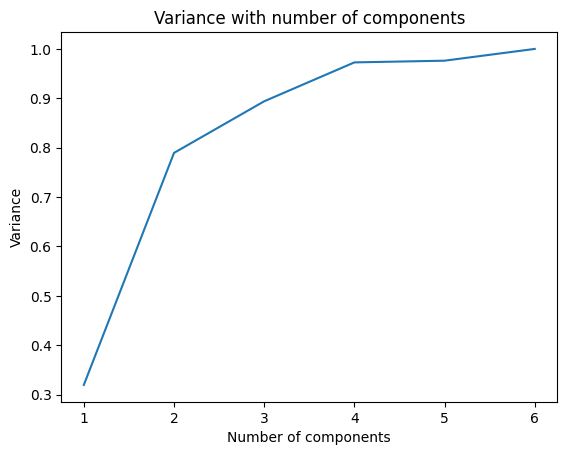

In [12]:
variance = []

for n in range(6):
    A_red, VT = get_svd_reduction_counts(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance));
plt.title("Variance with number of components")
plt.xlabel("Number of components")
plt.ylabel("Variance")


As you see, the variance increases up to 4 features and then stabilizes. This makes sense because we know that the last two features from our dataset did not hold much information. However, be aware that these four most important components are not the same four components in our table that hold the most information (like, hate, not, love).

Moreover, if some features in the original dataset are related, the whole dataset variance can be recovered with even less components. See what happens when we copy the values in "like" to "love" and "hate" to "not":

Text(0, 0.5, 'Variance')

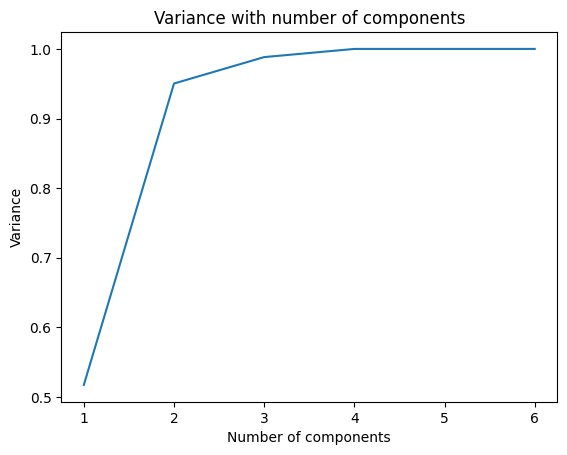

In [13]:
A = np.array([
    [5, 0, 0, 5, 1, 0],
    [2, 6, 6, 2, 0, 1],
    [3, 1, 1, 3, 2, 2],
    [2, 6, 6, 2, 0, 2],
    [0, 0, 0, 0, 0, 0],
    [2, 4, 4, 2, 1, 0],
])

variance = []

for n in range(6):
    A_red, VT = get_svd_reduction_counts(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance))
plt.title("Variance with number of components")
plt.xlabel("Number of components")
plt.ylabel("Variance")


As you can see, you can in fact attribute most of the variance to only two components, at about 95%. As a rule of thumb, you should aim at keeping over 85% of the variance explained with the reduced features. So our 95% result is actually very good, and it should show you that the SVD actually extracts meaningful features from your data. Feeling pretty awesome there, Neo?

<img src="media/neo-dodging-bullets.jpg" width="400">


Unfortunately not all cases - in particular, real cases - are so straightforward. Instead of using our implementation, we will move to the scikit-learn version, where you can use the TruncatedSVD class to apply this technique to your data, with more additional options. We will try it out with the data from the previous example.

## 2. SVD - NLP practical example using sk-learn

## 2.1 Start from baseline

As before, start by importing the dataset and getting a baseline. We will change from the multinomial naive Bayes we were using to a classifier that can handle negative numbers, because of the output of SVD. For now let us use a KNeighborsClassifier, which will try to classify the test points by their proximity to training examples. This is a very good classifier showing the usefulness of dimensionality reduction, since in very high-dimensional spaces, the dataset becomes too sparse and the data points cannot be effectively clustered.

In [14]:
# Fetch dataset
df = pd.read_csv('./datasets/twitter_rep_dem_data_small.csv')

# Feature Extraction
handle_removal = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_removal)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

train_data, test_data = train_test_split(df,  test_size=0.3, random_state=seed)
      
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

y_train = train_data.Party
y_test = test_data.Party

# Baseline
clf =  KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Accuracy: 0.5062994960403168


That's a pretty low baseline, as expected. It is actually similar to just randomly attributimg classes to our examples. Let's see if we can get more decent values by reducing the dimensionality of the data.

## 2.2 Applying SVD

We will now use the scikit-learn truncatedSVD class to obtain an SVD reduction of our data. This step might take a few minutes (>30 min), so just go ahead and grab a coffee, think about the nature of your reality, maybe try to bend some spoons, whatever makes you happy.

In [15]:
true_variance = []
explained_variance = []
accuracies = []

dense_X_train = X_train.toarray()
data_var = np.var(dense_X_train, axis=0).sum()

print('Total variance:')
print(data_var)

for n in [2, 10, 100, 200, 500, 1000]:
    print("\nComputing SVD for {} components".format(str(n)))
    svd = TruncatedSVD(n_components=n, random_state=seed)
    %timeit svd.fit(X_train)
    X_train_svd = svd.transform(X_train)
    X_test_svd =  svd.transform(X_test)
    print('\nVariance:')
    print(np.var(X_train_svd, axis=0).sum())
    true_variance.append(1.0*np.var(X_train_svd, axis=0).sum() / data_var)
    explained_variance.append(svd.explained_variance_)
    
    clf =  KNeighborsClassifier()
    clf.fit(X_train_svd, y_train)
    y_pred = clf.predict(X_test_svd)
    
    accuracies.append(accuracy_score(y_pred, y_test))
    print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Total variance:
0.9793720330999335

Computing SVD for 2 components
97.6 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Variance:
0.00715452836496948
Accuracy: 0.5122390208783297

Computing SVD for 10 components
242 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Variance:
0.03136989245907969
Accuracy: 0.5556155507559395

Computing SVD for 100 components
765 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.15140485224906092
Accuracy: 0.6083513318934485

Computing SVD for 200 components
1.36 s ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.22331815984981462
Accuracy: 0.6108711303095752

Computing SVD for 500 components
3.94 s ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.35643714950738736
Accuracy: 0.5932325413966882

Computing SVD for 1000 components
10 s ± 802 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.483406589156116
Accuracy: 0.5701943844492

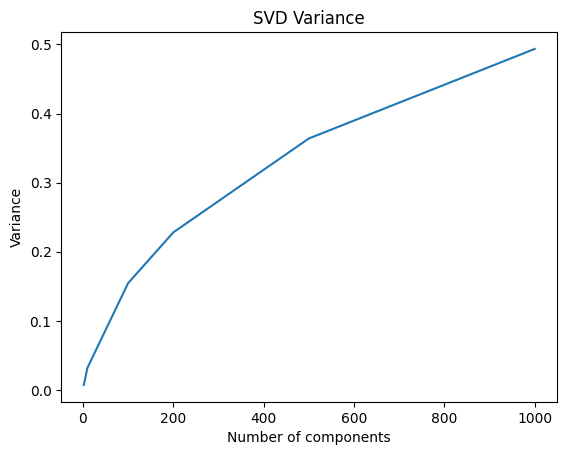

In [16]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(true_variance));
plt.title("SVD Variance");
plt.xlabel("Number of components");
plt.ylabel("Variance");


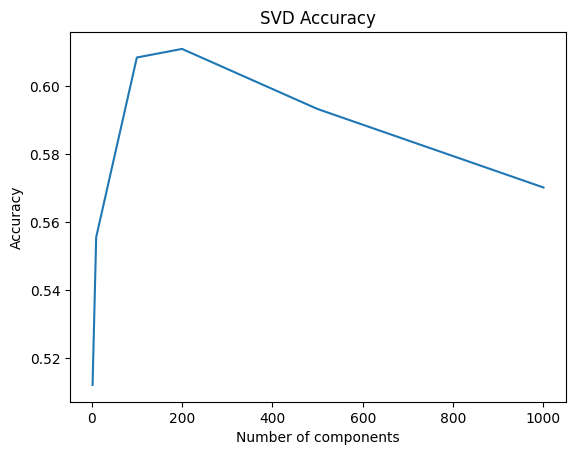

In [17]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(accuracies));
plt.title("SVD Accuracy");
plt.xlabel("Number of components");
plt.ylabel("Accuracy");


These results show that high dimensionality can sometimes reduce the performance. In this particular case, neither a high number of features nor a too low number of features result in good performance. Let's move forward to our second method, which is closely related to SVD - the principal component analysis - and see if the results hold.\

**Note**: variance always increase because we just keep adding components, and each component will "explain" a bit more of the data's variance.

## 3. Principal component analysis

This idea of applying Principal Component Analysis for dimensionality reduction is very similar to the one of SVD. In fact, SVD can be used just as a mathematical way of solving PCA and several numerical software libraries actually use SVD under the hood for their PCA routines - take as an example the scikit-learn implementation. So what is PCA?

In the same way as before, PCA aims to project the data into a lower dimensionality space, maximizing the variance of the projection along each component while minimizing the reconstruction error. We need to introduce a new concept - the covariance matrix and the correlation matrix.

Given our training set as a sequence of data points $\{x^1, x^2, ..., x^K\}$, a matrix $A$ that represents this dataset, and its mean as $\mu = \langle A \rangle$, the covariance matrix is represented by:

$$cov(A) = \langle(A - \mu)(A - \mu)^T\rangle = \frac{(A - \mu)(A - \mu)^T}{n-1}$$

where each row is a variable and each column an observation, and the correlation matrix is simply

$$corr(A) = \langle A A^T\rangle$$

In the study of principal components, we are interested in the variation of the data about the mean, so we normally first compute the centered data:

$$ \bar{A} = A - \mu$$

with the result that $cov(\bar{A}) = corr(\bar{A})$, since the data will have zero mean.

## 3.1 Getting the first principal component

We can now define the first component as the projection of our data in some direction represented by the vector $\textbf{w}$, where the scale doesn't matter since it does not affect the information contained in this component:

$$p_1 = \textbf{w}^T \bar{A}$$

If you still don't feel comfortable in linear algebra, skip the next few equations from now and read directly the TL,DR.

-------

We choose this vector to maximize the variance of $p_1$:

$$\sigma^2_{p_1} = \langle p_1^2 \rangle = \langle (\textbf{w}^T \bar{A})(\bar{A}^T\textbf{w}) \rangle = \textbf{w}^T \langle \bar{A} \bar{A}^T\rangle \textbf{w} = \textbf{w}^T cov(A) \textbf{w} $$

If we define our vector $\textbf{w}$ as a linear combination of the eigenvectors of our covariance matrix, with weights $w_i$ and eigenvectors $\textbf{v}_i$:

$$\textbf{w} = \sum_i{w_i \textbf{v}_i}$$

$$\sigma^2_{p_1} = \textbf{w}^T cov(A) (\sum_i{w_i \textbf{v}_i}) = \sum_i{w_i \textbf{w}^T cov(A)\textbf{v}_i}$$

Remember that one of the main definitions of eigenvectors is that their direction remains unchanged when applying the linear transformation ($Mv=\lambda v$). Also note that, if $\textbf{v}_i$ are vectors from an orthonormal basis, then $\textbf{v}_i\textbf{v}_j = 0$ and $\textbf{v}_i\textbf{v}_i = 1$, so we can write:

$$\textbf{w}^T \textbf{v}_i = w_i $$

And our previous result simplifies to:

$$\sigma^2_{p_1} = \sum_i{w_i \lambda_i \textbf{w}^T \textbf{v}_i} = \sum_i{w_i^2 \lambda_i}  $$

This is the quantity we want to maximize, constrained to $\sum_i{w_i^2} = 1 $, so it should be clear that the maximum should be attained by setting $w_i = 1$ for the highest eigenvalue of $cov(A)$ and zero to all other weights. The first component will then be:

$$ p_1 = \textbf{v}_1 \bar{A}$$

And a reconstruction of $\bar{A}$ would be obtained by:

$$ \bar{A} =  p_1 \textbf{v}_1$$

And the variance of this compoment will just be $\sigma^2_{p_1} = \lambda_i$ for the highest eigenvalue.

-------

### **TL,DR**: 
You can write out the first component as a function of the eigenvectors and eigenvalues of the covariance matrix of $\bar{A}$, if these are ordered from highest eigenvalue to lowest: 

$$p_1 = \textbf{v}_1 \bar{A}$$

and the variance associated with this component will be:

$$\sigma^2_{p_1} = \lambda_1$$

This can be extended to the following components, and so the procedure to get a PCA reduction is quite simple. Let's try it out like we did for SVD.

### 3.1.1 Choose A

Let's reuse the same matrix  A that we had before:

|          |  like | hate | not | love |
|----------|-------|------|-----|------|
| Positive |  5    |  0   |  2  |   4  |
| Negative |  2    |  6	  |  1  |   2  |


In [18]:
A = np.array([
    [5, 0, 2, 4],
    [2, 6, 1, 2]
])

print("\nMatrix to decompose:")
print(A)


Matrix to decompose:
[[5 0 2 4]
 [2 6 1 2]]


### 3.1.2 Center A and compute the covariance matrix

We now need to center our data. First, be careful with the dimension you choose - you want to average across samples and get a vector with the size of your feature space. Then we can compute the covariance matrix: 


In [19]:
u = np.mean(A, axis=0)

centA = A - u

print("\nCentered data:")
print(centA)

# The covariance is an average of (A - u)(A -u)^T 
covA = np.matmul(centA.T, centA)/A.shape[0]

print("\nCovariance Matrix:")
print(covA)


Centered data:
[[ 1.5 -3.   0.5  1. ]
 [-1.5  3.  -0.5 -1. ]]

Covariance Matrix:
[[ 2.25 -4.5   0.75  1.5 ]
 [-4.5   9.   -1.5  -3.  ]
 [ 0.75 -1.5   0.25  0.5 ]
 [ 1.5  -3.    0.5   1.  ]]


### 3.1.3 Get the covariance matrix eigenvalues 

In [20]:
lmbV, V = np.linalg.eig(covA)
print(V)

[[-0.90553851 -0.42426407 -0.90553851 -0.14142136]
 [-0.39755349  0.84852814 -0.39755349  0.28284271]
 [ 0.06625892 -0.14142136  0.06625892  0.42426407]
 [ 0.13251783 -0.28284271  0.13251783  0.84852814]]


### 3.1.4 Project data into the first component

In [21]:
A_red = np.matmul(centA, V[:, 0])

print(A_red)

[ 2.22044605e-16 -2.22044605e-16]


## 3.2 Putting it all together

Let's put these steps together and try out dimensionality reduction with PCA:

In [22]:
def get_pca_reduction(A, n_components):
    
    u = np.mean(A, axis=0)
    covA = np.matmul(A.T, A)
    lmbV, V = np.linalg.eig(covA)
    V_red = V[:,:n_components]
    A_red = np.matmul(A, V_red)
    var = lmbV

    return A_red, V_red, var

Once again, we are going to reuse the matrix from the SVD example:

|          |  like | hate | not | love | movie | book |
|----------|-------|------|-----|------|-------|------|
| Positive |  5    |  0   |  2  |   4  |   1   |   0  |
| Negative |  2    |  6	  |  1  |   2  |   0   |   1  |  
| Positive |  3    |  1   |  1  |   4  |   2   |   1  |
| Negative |  2    |  6	  |  1  |   5  |   0   |   2  |
| Negative |  0    |  0   |  3  |   1  |   0   |   0  |
| Negative |  2    |  4	  |  0  |   1  |   1   |   0  |

Let's define our matrix as a numpy array:

In [23]:
A = np.array([
    [5, 0, 2, 4, 1, 0],
    [2, 6, 1, 2, 0, 1],
    [3, 1, 1, 4, 2, 2],
    [2, 6, 1, 5, 0, 2],
    [0, 0, 3, 1, 0, 0],
    [2, 4, 0, 1, 1, 0],
])

We will now plot the variance and see how different components have different variances.

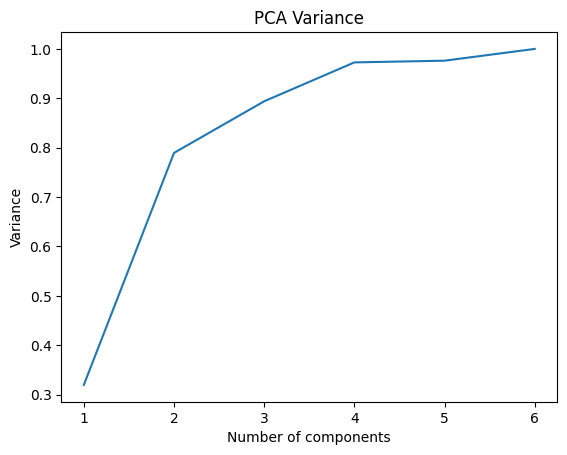

In [24]:
variance = []

for n in range(6):
    A_red, V, var = get_pca_reduction(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance));
plt.title("PCA Variance");
plt.xlabel("Number of components");
plt.ylabel("Variance");


## 4. PCA - NLP practical example using sk-learn

## 4.1 Start from baseline

We will now go back to our real example. We'll start from the same baseline as 2.1 

In [25]:
df = pd.read_csv('./datasets/twitter_rep_dem_data_small.csv')

# Feature Extraction
handle_removal = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_removal)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)
      
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

y_train = train_data.Party
y_test = test_data.Party

clf =  KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Baseline Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Baseline Accuracy: 0.5062994960403168


## 4.2 Applying PCA

We will now use the scikit-learn PCA class to reduce the features. Once again, go grab that coffee and take a walk, 'cause this might take a while.

In [26]:
variance = []
accuracies = []

dense_X_train = X_train.toarray()
dense_X_test = X_test.toarray()
data_var = np.var(dense_X_train, axis=0).sum()

print('Total variance:')
print(data_var)

for n in [2, 10, 100, 200, 500, 1000]:
    print("\nComputing PCA for {} components".format(str(n)))
    pca = PCA(n_components=n, random_state=seed)
    %timeit pca.fit(dense_X_train)
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca = pca.transform(dense_X_test)
    
    print('\nVariance:')
    print(np.var(X_train_pca, axis=0).sum())
    variance.append(1.0*np.var(X_train_pca, axis=0).sum() / data_var)
    
    clf =  KNeighborsClassifier()
    %timeit clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    
    accuracies.append(accuracy_score(y_pred, y_test))
    print('\nAccuracy: {}'.format(accuracy_score(y_pred, y_test)))

Total variance:
0.9793720330999335

Computing PCA for 2 components
8.89 s ± 730 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.008843292423477853
7.29 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.5260979121670266

Computing PCA for 10 components
11.8 s ± 896 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.032669085753682645
7.62 ms ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.5413966882649388

Computing PCA for 100 components
22.5 s ± 749 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.15257216765155274
5.25 ms ± 8.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.6042116630669546

Computing PCA for 200 components
29.1 s ± 1.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.22463714266185258
5.56 ms ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Accuracy: 0.6099712023038157

Computing PCA for 500 component

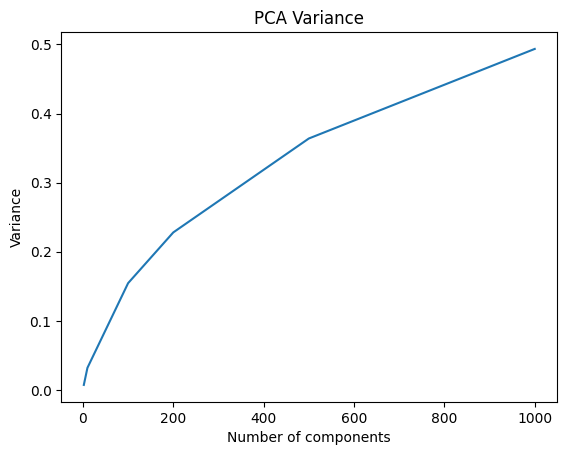

In [27]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(true_variance));
plt.title("PCA Variance");
plt.xlabel("Number of components");
plt.ylabel("Variance");


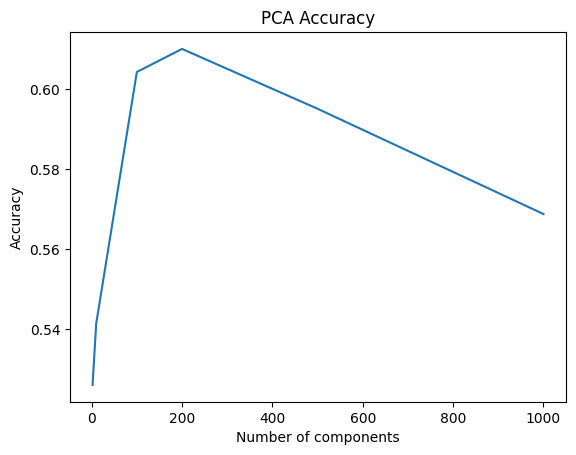

In [28]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(accuracies));
plt.title("PCA Accuracy");
plt.xlabel("Number of components");
plt.ylabel("Accuracy");


The results are similar to the ones obtained with SVD, which is intuitive since both methods try to obtain meaningful components that represent the data. As mentioned before, the use of this classifier points out the problems of high dimensional data, and should show you that these methods can be very useful in solving that problem.


## 5. Final Remarks

We went through PCA and SVD in this notebook, which are methods you can try out with virtually any kind of data, whether your purpose is compression, visualization or just dimensionality reduction for classification. Some final notes:

1 - You must have realized by now that the performance of the methods is tightly coupled to the classifier you choose, and that methods that intuitively seem to be good will not always help you in your tasks. This doesn't mean that the methods aren't good, simply that you first need think of the model you are using and whether you really need or expect an improvement over your baseline.

2 - You can combine methods like this with other feature selection and engineering techniques you saw before. As in many fields, trying out these techniques in different scenarios will give you a better feeling of when they can be helpful or when they will actually be harmful.

We're finally done! Now rest a bit, go for a walk, and then dive into Part III. But before you go, I'll leave you with these questions:

<img src="media/matrix-questions-existencial.jpg" width="700">

